# 1. Imports and configuration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set(style="whitegrid")

DATA_PATH = "../../data/freMTPL2freq.csv"

# 2. Load raw data and basic structure

Goals:
- Confirm basic shape and dtypes.
- Get a quick feel for numeric ranges.

In [4]:
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nInfo:")
df.info()

num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=["object", "category"]).columns

print("\nNumeric columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

print("\nDescriptive statistics (numeric):")
display(df[num_cols].describe())

Shape: (678013, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 62.1+ MB

Numeric columns: ['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
Categorical columns: ['Area', 'VehBrand', 'VehGas', 'Region']

Descriptive statistics (numeric):


,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


# 3. Data quality: missing values and zeros

Why:
- Missing values can break downstream models or bias results.
- Zero values in numeric columns are not always a problem, but are important for risk measures (e.g. Exposure) and some engineered ratios.

,missing_cnt,missing_frac,zero_cnt,zero_frac
IDpol,0,0.0,0,0.000000
ClaimNb,0,0.0,643953,0.949765
Exposure,0,0.0,0,0.000000
Area,0,0.0,0,0.000000
VehPower,0,0.0,0,0.000000
VehAge,0,0.0,57739,0.085159
DrivAge,0,0.0,0,0.000000
BonusMalus,0,0.0,0,0.000000
VehBrand,0,0.0,0,0.000000
VehGas,0,0.0,0,0.000000


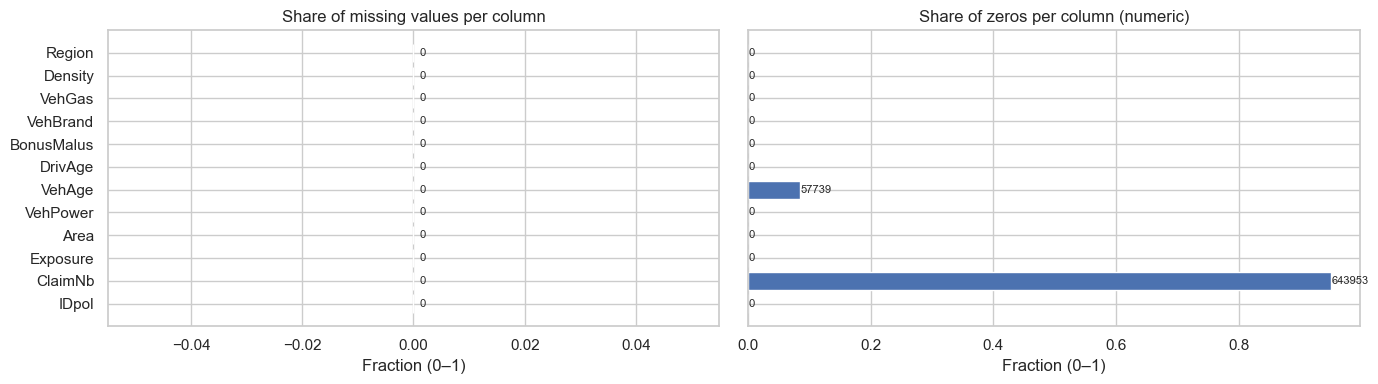

In [3]:
def overview_missing_zero(df: pd.DataFrame) -> None:
    """
    High-level data quality view:
    - missing_cnt / missing_frac for all columns,
    - zero_cnt / zero_frac for numeric columns.
    """
    n_rows = len(df)

    stats = pd.DataFrame(index=df.columns)
    stats["missing_cnt"] = df.isna().sum()
    stats["missing_frac"] = stats["missing_cnt"] / n_rows

    num_cols = df.select_dtypes(include=[np.number]).columns
    zero_cnt = (df[num_cols] == 0).sum()

    stats["zero_cnt"] = 0
    stats.loc[num_cols, "zero_cnt"] = zero_cnt
    stats["zero_frac"] = stats["zero_cnt"] / n_rows

    stats = stats.sort_values("missing_frac", ascending=False)

    display(stats)

    fig, axes = plt.subplots(
        1, 2,
        figsize=(14, max(4, len(stats) * 0.3)),
        sharey=True,
    )

    # Missing fractions
    axes[0].barh(stats.index, stats["missing_frac"])
    axes[0].set_title("Share of missing values per column")
    axes[0].set_xlabel("Fraction (0–1)")

    for i, (val, cnt) in enumerate(zip(stats["missing_frac"], stats["missing_cnt"])):
        axes[0].text(val + 0.001, i, f"{cnt}", va="center", fontsize=8)

    # Zero fractions for numeric
    axes[1].barh(stats.index, stats["zero_frac"])
    axes[1].set_title("Share of zeros per column (numeric)")
    axes[1].set_xlabel("Fraction (0–1)")

    for i, (val, cnt) in enumerate(zip(stats["zero_frac"], stats["zero_cnt"])):
        axes[1].text(val + 0.001, i, f"{int(cnt)}", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()


overview_missing_zero(df)

# 4. Numeric distributions and transformation diagnostics
 
Why:
- Identify skewness, outliers and heavy tails.
- Justify simple transformations (e.g. log(Density)).
- Get a feeling for how to define business-friendly bands for GLMs.

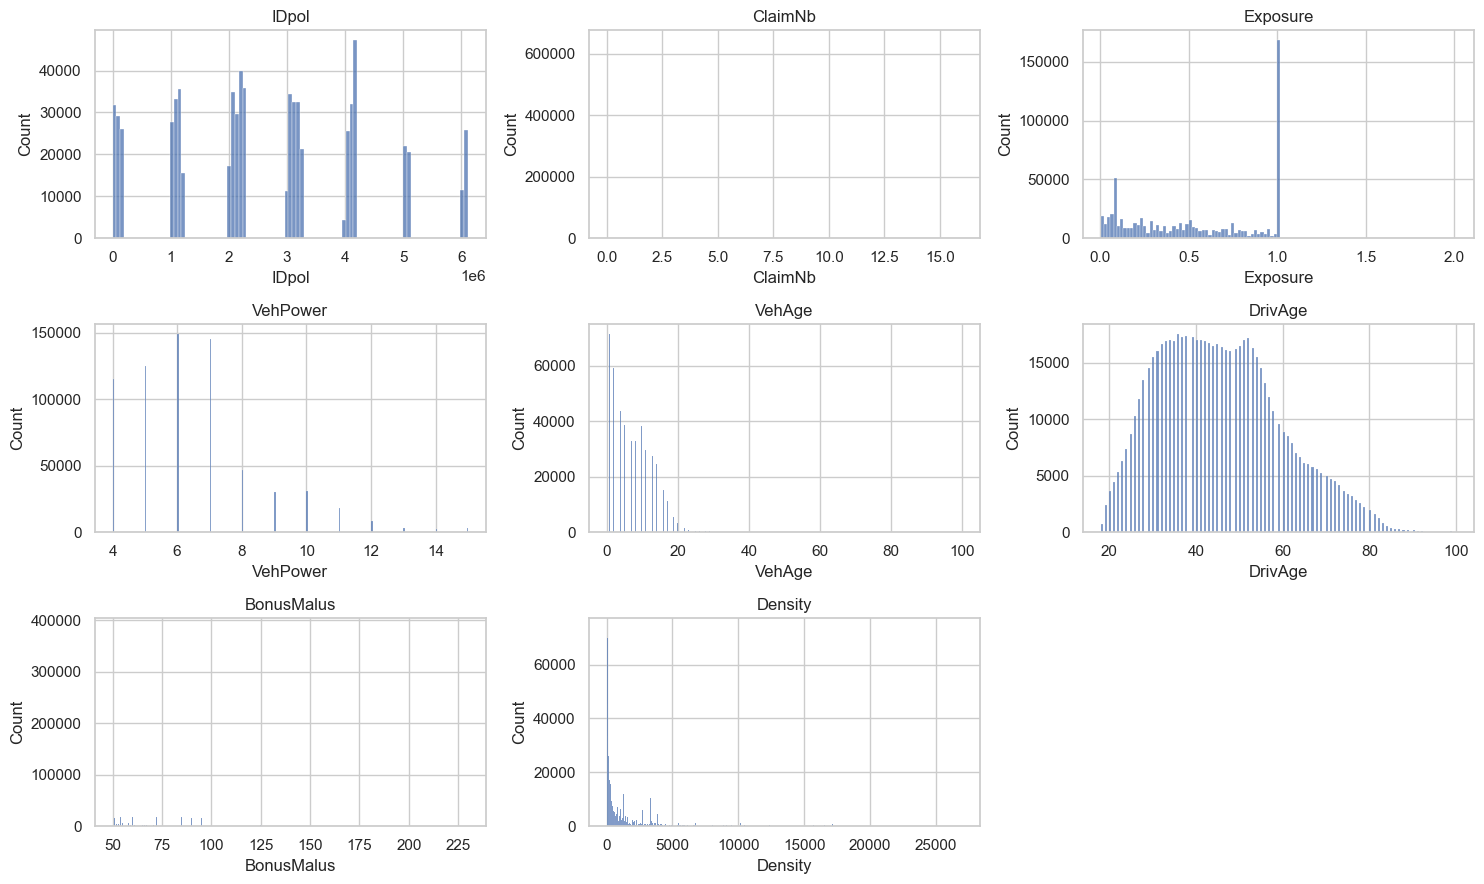

In [4]:
def plot_numeric_distributions(df: pd.DataFrame) -> None:
    """
    Univariate histograms for all numeric variables.
    Supports quick detection of skewness and outliers.
    """
    num_cols = df.select_dtypes(include=[np.number]).columns
    n = len(num_cols)
    ncols = 3
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        ax = axes[i]
        sns.histplot(df[col], kde=False, ax=ax)
        ax.set_title(col)

    # Remove unused axes (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


plot_numeric_distributions(df)

# 4.1 DrivAge – distribution and candidate bands

DrivAge – shape of the portfolio and candidate bands for GLM-style models.
Histogram suggests:
- growth in volume up to ~30,
- plateau between ~30 and 50,
- decline after 50.
These patterns motivate broad, business-friendly bands around these ranges.

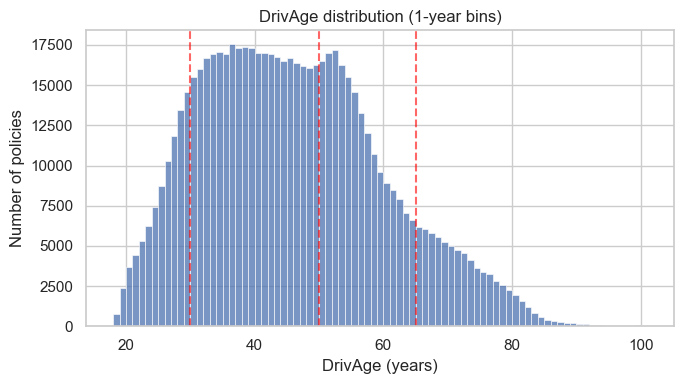

C:\Users\shomi\AppData\Local\Temp\ipykernel_21752\4283267474.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("DrivAge2y")


,exposure,claims,claim_freq
DrivAge2y,,,
"[18, 20)",1123.603681,308,0.274118
"[20, 22)",3281.080296,688,0.209687
"[22, 24)",4896.313358,909,0.185650
"[24, 26)",6926.905929,936,0.135125
"[26, 28)",9655.959079,1157,0.119822
"[28, 30)",12390.559323,1265,0.102094
"[30, 32)",14653.478697,1352,0.092265
"[32, 34)",15900.669999,1411,0.088738
"[34, 36)",16666.110978,1477,0.088623


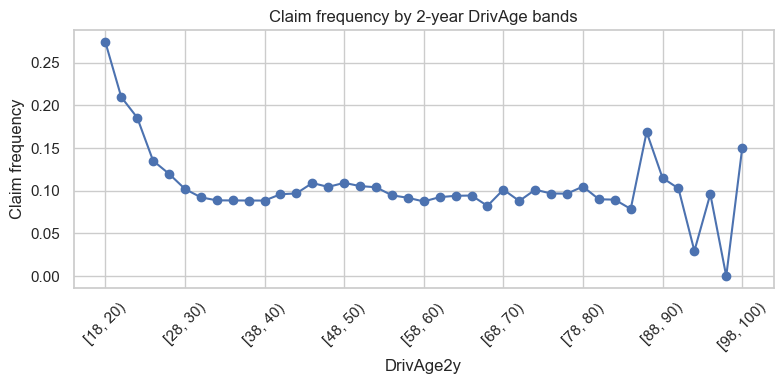

In [5]:
plt.figure(figsize=(7, 4))
sns.histplot(df["DrivAge"], bins=range(18, 102), kde=False)
plt.xlabel("DrivAge (years)")
plt.ylabel("Number of policies")
plt.title("DrivAge distribution (1-year bins)")

for cut in [30, 50, 65]:
    plt.axvline(cut, color="red", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Sanity check: claim frequency by 2-year DrivAge bands.
# Purpose:
# - confirm that claim frequency changes smoothly with age,
# - ensure that final bands do not hide any large jumps in risk.
drivage_freq = (
    df
    .assign(
        DrivAge2y=lambda d: pd.cut(
            d["DrivAge"],
            bins=range(18, 102, 2),
            right=False,
        )
    )
    .groupby("DrivAge2y")
    .agg(
        exposure=("Exposure", "sum"),
        claims=("ClaimNb", "sum"),
    )
)
drivage_freq["claim_freq"] = drivage_freq["claims"] / drivage_freq["exposure"]

display(drivage_freq.head(10))

plt.figure(figsize=(8, 4))
drivage_freq["claim_freq"].plot(marker="o")
plt.ylabel("Claim frequency")
plt.title("Claim frequency by 2-year DrivAge bands")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4.2 VehAge – distribution and motivation for bands

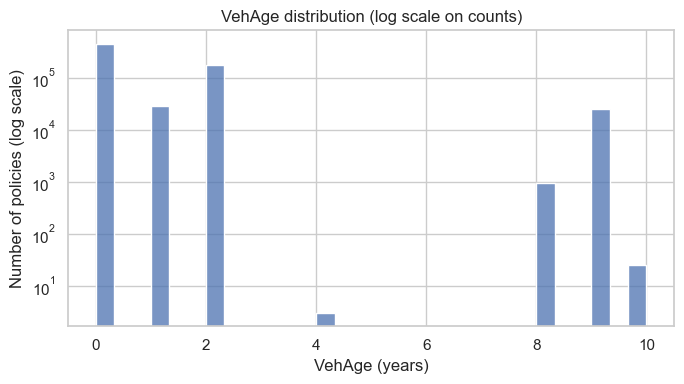

In [6]:
vehage_pos = df.loc[df["VehAge"], "VehAge"]

plt.figure(figsize=(7, 4))
sns.histplot(vehage_pos, bins=30, kde=False)
plt.yscale("log")  # log-scale on number of policies
plt.xlabel("VehAge (years)")
plt.ylabel("Number of policies (log scale)")
plt.title("VehAge distribution (log scale on counts)")
plt.tight_layout()
plt.show()

# 4.3 BonusMalus – distribution and bonus/malus bands

BonusMalus: truncate extremes for visualization and use log-scale on counts.
Most of the business sits in low-BM classes, with a thin high-malus tail.
This supports grouping the extremes into a single high-malus band.

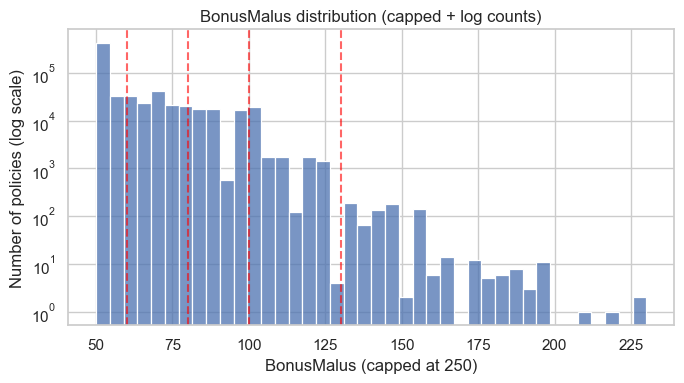

In [7]:
bm_clip = df["BonusMalus"].clip(upper=250)

plt.figure(figsize=(7, 4))
sns.histplot(bm_clip, bins=40, kde=False)
plt.yscale("log")
plt.xlabel("BonusMalus (capped at 250)")
plt.ylabel("Number of policies (log scale)")
plt.title("BonusMalus distribution (capped + log counts)")

# Candidate BM bands used later: 50–59, 60–79, 80–99, 100–129, 130+
for cut in [60, 80, 100, 130]:
    plt.axvline(cut, color="red", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# 4.4 Density vs log(Density) – justification for log transform

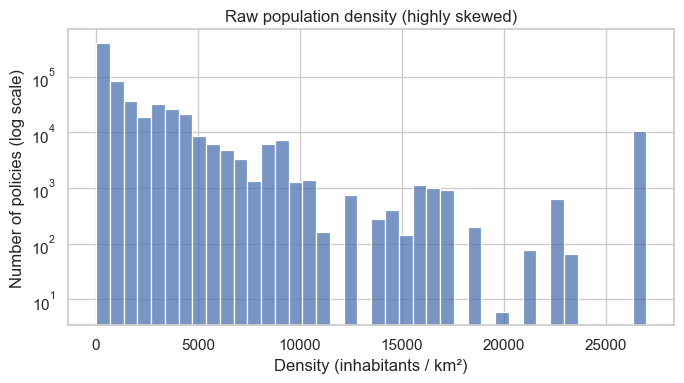

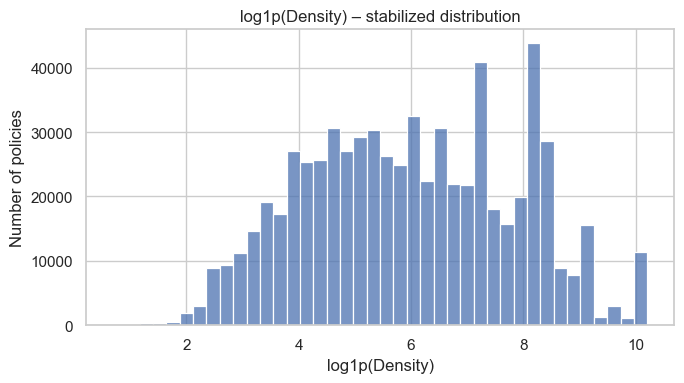

In [8]:
# Raw density is extremely right-skewed.
plt.figure(figsize=(7, 4))
sns.histplot(df["Density"], bins=40, kde=False)
plt.yscale("log")
plt.xlabel("Density (inhabitants / km²)")
plt.ylabel("Number of policies (log scale)")
plt.title("Raw population density (highly skewed)")
plt.tight_layout()
plt.show()

# log1p(Density) stabilizes the distribution and makes it easier to model.
plt.figure(figsize=(7, 4))
sns.histplot(np.log1p(df["Density"]), bins=40, kde=False)
plt.xlabel("log1p(Density)")
plt.ylabel("Number of policies")
plt.title("log1p(Density) – stabilized distribution")
plt.tight_layout()
plt.show()

# 4.5 VehPower – distribution and risk by power class

VehPower is a discrete rating factor (engine power class).
This section inspects:
- how exposure is distributed across classes,
- how claim frequency behaves by power level.

The goal is to justify grouping into low / medium / high / very high bands.

,exposure,claims,policies,claim_freq
VehPower,,,,
4,60073.637304,5699,115349,0.094867
5,68173.348821,7278,124821,0.106757
6,82524.210172,8381,148976,0.101558
7,77950.456700,7627,145401,0.097844
8,22684.616305,1922,46956,0.084727
9,15348.213656,1754,30085,0.114280
10,15375.010824,1789,31354,0.116358
11,8497.778452,897,18352,0.105557
12,3792.038343,359,8214,0.094672


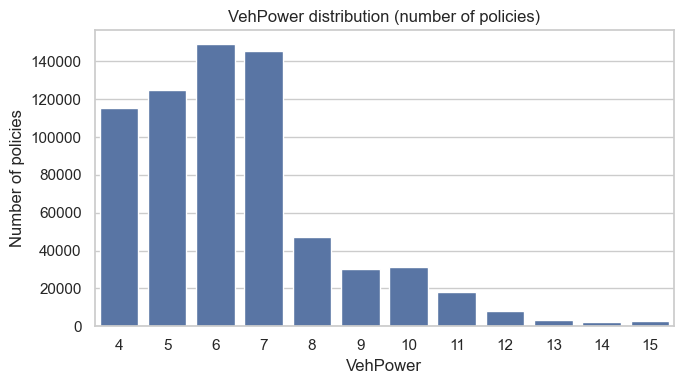

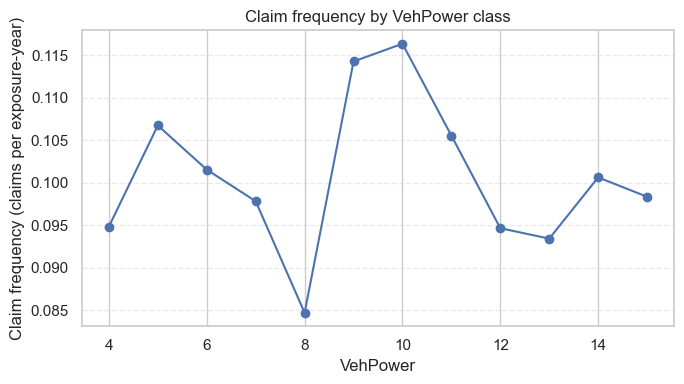

In [9]:
power_summary = (
    df
    .groupby("VehPower")
    .agg(
        exposure=("Exposure", "sum"),
        claims=("ClaimNb", "sum"),
        policies=("IDpol", "count"),
    )
    .sort_index()
)

power_summary["claim_freq"] = power_summary["claims"] / power_summary["exposure"]

display(power_summary.head(15))

# Policies by VehPower
plt.figure(figsize=(7, 4))
sns.barplot(
    x=power_summary.index.astype(str),
    y=power_summary["policies"],
)
plt.xlabel("VehPower")
plt.ylabel("Number of policies")
plt.title("VehPower distribution (number of policies)")
plt.tight_layout()
plt.show()

# Claim frequency by VehPower
plt.figure(figsize=(7, 4))
plt.plot(
    power_summary.index,
    power_summary["claim_freq"],
    marker="o",
)
plt.xlabel("VehPower")
plt.ylabel("Claim frequency (claims per exposure-year)")
plt.title("Claim frequency by VehPower class")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 5. Rare-category analysis for VehBrand and Region

Why:
- Very small categories can create unstable GLM parameters and noisy tree splits.
- Lumping rare levels into an `Other` bucket stabilizes the model while preserving the main structure of the portfolio.

This section only explores **how many** levels would be lumped at different thresholds; the actual lumping is implemented in the data preparation notebook.

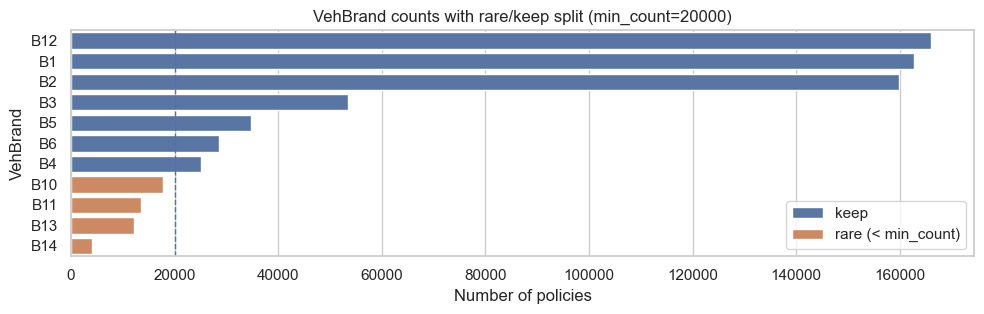

VehBrand: 11 raw levels
Levels below min_count: 4
Share of policies in rare levels: 7.008%


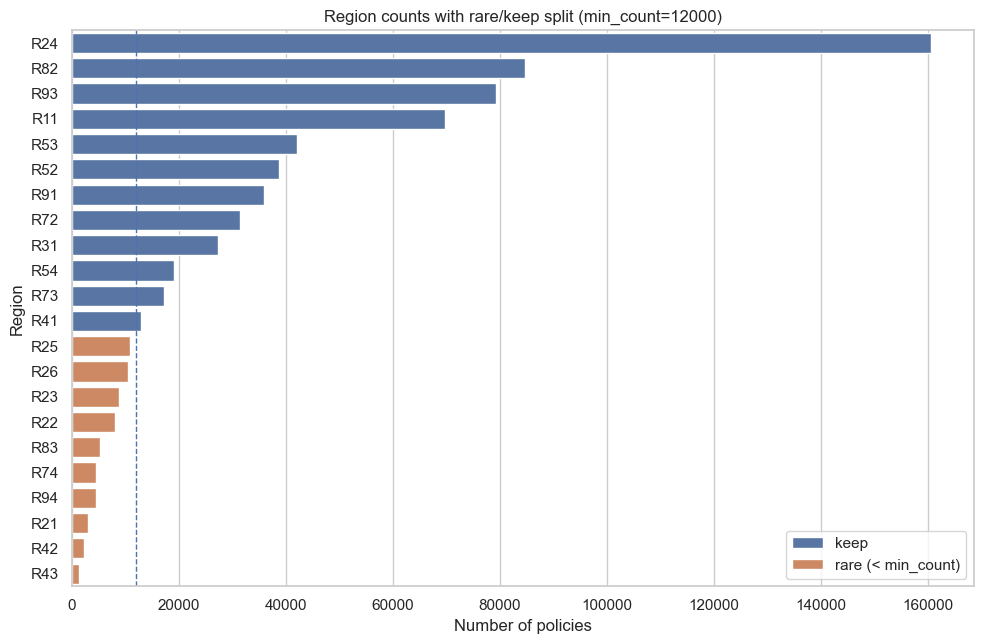

Region: 22 raw levels
Levels below min_count: 10
Share of policies in rare levels: 8.714%


In [10]:
def plot_lumping_decision(
    df: pd.DataFrame,
    col: str,
    min_count: int = 15000,
    top_n: int | None = None,
) -> None:
    """
    Visual check for how to lump rare categories.

    For a given column:
    - plots value counts,
    - highlights levels below `min_count`,
    - prints how many levels are considered rare and what fraction of policies
      they represent.
    """
    counts = df[col].value_counts().sort_values(ascending=False)

    if top_n is not None:
        counts = counts.head(top_n)

    rare_mask = counts < min_count
    rare_labels = np.where(rare_mask, "rare (< min_count)", "keep")

    plt.figure(figsize=(10, max(3, 0.3 * len(counts))))
    sns.barplot(
        x=counts.values,
        y=counts.index,
        hue=rare_labels,
        dodge=False,
    )
    plt.axvline(min_count, linestyle="--", linewidth=1)
    plt.xlabel("Number of policies")
    plt.ylabel(col)
    plt.title(f"{col} counts with rare/keep split (min_count={min_count})")
    plt.legend(title="")
    plt.tight_layout()
    plt.show()

    n_levels = len(counts)
    n_rare = rare_mask.sum()
    share_policies_rare = counts[rare_mask].sum() / counts.sum()

    print(f"{col}: {n_levels} raw levels")
    print(f"Levels below min_count: {n_rare}")
    print(f"Share of policies in rare levels: {share_policies_rare:.3%}")


# Lumping thresholds visually assessed here;
# chosen min_count values are reused later in data preparation.
plot_lumping_decision(df, "VehBrand", min_count=20000)
plot_lumping_decision(df, "Region",   min_count=12000)

# 6. Categorical frequency plots

Why:
- Show how the portfolio is distributed by key categorical factors.
- Helpful for understanding where most of the exposure and claims sit.

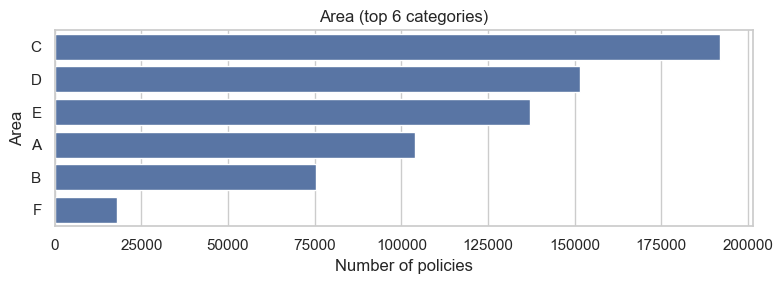

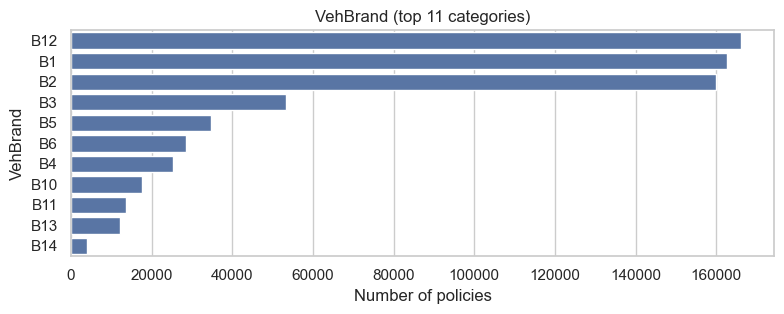

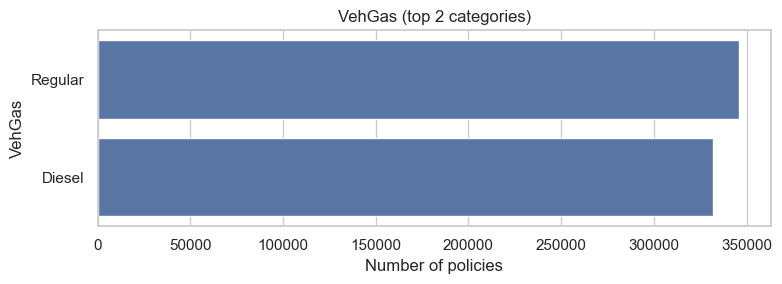

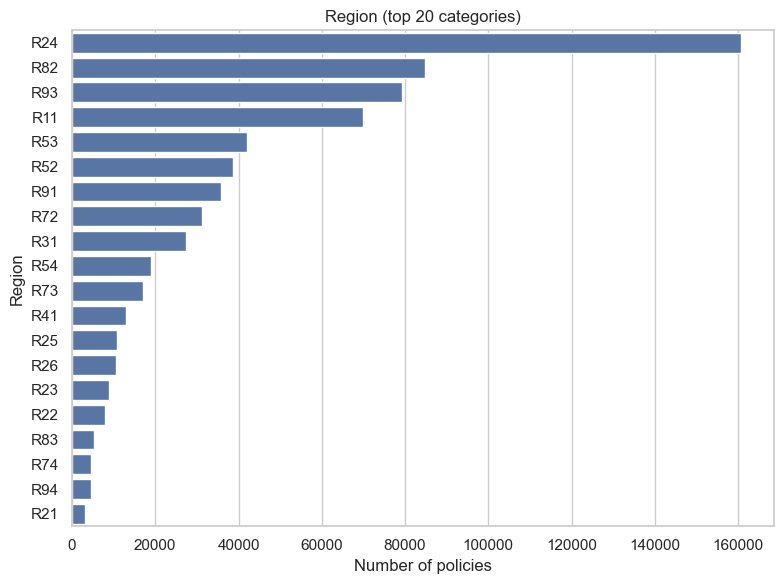

In [11]:
def plot_categorical_counts(df: pd.DataFrame, max_levels: int = 20) -> None:
    """
    Horizontal bar plots for the top `max_levels` categories per categorical column.
    """
    cat_cols = df.select_dtypes(include=["object", "category"]).columns

    for col in cat_cols:
        counts = df[col].value_counts().head(max_levels)

        plt.figure(figsize=(8, max(3, len(counts) * 0.3)))
        sns.barplot(x=counts.values, y=counts.index)
        plt.title(f"{col} (top {len(counts)} categories)")
        plt.xlabel("Number of policies")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()


plot_categorical_counts(df)

# 7. Basic keys and core value_counts

Why:
- Confirm that IDpol behaves like a key.
- Quick value_counts for core rating variables and ClaimNb.

In [12]:
print("Number of unique policies (IDpol):", df["IDpol"].nunique())

print("\nFirst few value_counts for key features:")
for col in [
    "ClaimNb",
    "Exposure",
    "Area",
    "VehPower",
    "VehAge",
    "DrivAge",
    "BonusMalus",
    "VehGas",
    "Region",
]:
    if col in df.columns:
        print(f"\n--- {col} ---")
        print(df[col].value_counts().head(10))


Number of unique policies (IDpol): 678013

First few value_counts for key features:

--- ClaimNb ---
ClaimNb
0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
16         1
Name: count, dtype: int64

--- Exposure ---
Exposure
1.00    168125
0.08     44670
0.07     12969
0.24     12950
0.50     12497
0.49     12298
0.03     11996
0.04     11131
0.12     11047
0.20      8727
Name: count, dtype: int64

--- Area ---
Area
C    191880
D    151596
E    137167
A    103957
B     75459
F     17954
Name: count, dtype: int64

--- VehPower ---
VehPower
6     148976
7     145401
5     124821
4     115349
8      46956
10     31354
9      30085
11     18352
12      8214
13      3229
Name: count, dtype: int64

--- VehAge ---
VehAge
1     71284
2     59124
0     57739
3     50261
4     43492
5     38737
10    38395
6     35717
7     32880
8     32680
Name: count, dtype: int64

--- DrivAge ---
DrivAge
36    17530
38    17346
39    17320
37

# 8. Claim frequency definition and segment summaries

Claim frequency is the central business metric: expected number of claims per unit of exposure (year).

In [13]:
df["ClaimFreq"] = df["ClaimNb"] / df["Exposure"]
display(df["ClaimFreq"].describe())

# %%
def summarize_claim_frequency(
    df: pd.DataFrame,
    by: str,
    min_policies: int = 1000,
) -> pd.DataFrame:
    """
    Aggregate exposure, claims and claim frequency by a categorical feature.

    Returns a table with:
    - policies,
    - total exposure,
    - total claims,
    - claim frequency (claims per exposure-year),
    filtered to groups with at least `min_policies` policies.
    """
    summary = (
        df.groupby(by)
          .agg(
              policies=("IDpol", "count"),
              exposure=("Exposure", "sum"),
              claims=("ClaimNb", "sum"),
          )
    )
    summary["claim_freq"] = summary["claims"] / summary["exposure"]
    summary = summary[summary["policies"] >= min_policies]
    return summary.sort_values("claim_freq", ascending=False)


area_summary = summarize_claim_frequency(df, "Area")
display(area_summary)

region_summary = summarize_claim_frequency(df, "Region", min_policies=5000)
display(region_summary.head(10))

vehgas_summary = summarize_claim_frequency(df, "VehGas")
display(vehgas_summary)

count    678013.000000
mean          0.263964
std           4.593915
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         732.000000
Name: ClaimFreq, dtype: float64

,policies,exposure,claims,claim_freq
Area,,,,
F,17954,8129.234074,1131,0.139127
E,137167,63819.314270,7805,0.122298
D,151596,77120.191692,8428,0.109284
C,191880,104449.003785,9875,0.094544
B,75459,43012.323931,3800,0.088347
A,103957,61969.377712,5063,0.081702


,policies,exposure,claims,claim_freq
Region,,,,
R11,69791,30208.641954,3978,0.131684
R22,7994,3574.410221,439,0.122817
R82,84752,45347.417286,5032,0.110966
R93,79315,35790.321015,3907,0.109164
R91,35805,14736.104177,1547,0.104980
R31,27285,11497.974269,1176,0.102279
R26,10492,5025.358609,511,0.101684
R73,17141,7020.108555,688,0.098004
R53,42122,27753.463675,2702,0.097357


,policies,exposure,claims,claim_freq
VehGas,,,,
Regular,345877,187838.552336,19454,0.103568
Diesel,332136,170660.893127,16648,0.097550


# 9. Claim frequency by segment (visuals)

Why:
- Compare relative risk across segments.
- Check whether patterns make sense from underwriting / pricing perspective.

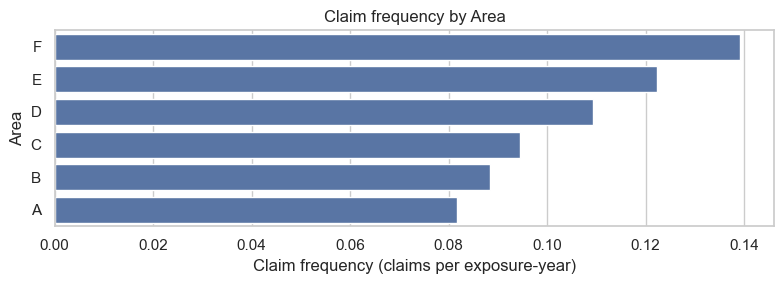

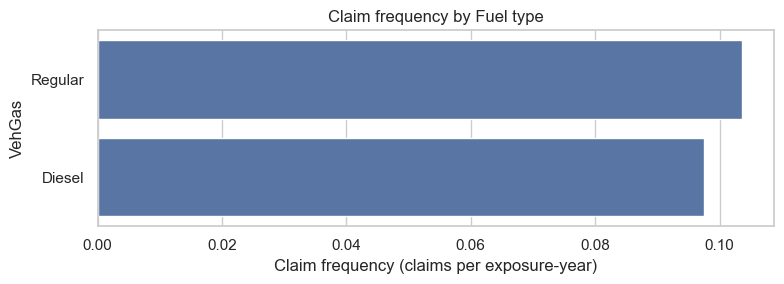

In [14]:
def plot_claim_frequency(summary: pd.DataFrame, title: str) -> None:
    """
    Horizontal bar plot for claim frequency by segment.
    Expects a DataFrame with index as segment name and a 'claim_freq' column.
    """
    plt.figure(figsize=(8, max(3, 0.4 * len(summary))))
    sns.barplot(x=summary["claim_freq"], y=summary.index)
    plt.xlabel("Claim frequency (claims per exposure-year)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_claim_frequency(area_summary, "Claim frequency by Area")
plot_claim_frequency(vehgas_summary, "Claim frequency by Fuel type")

# 10. Target and exposure sanity checks
 
Goals:
- Confirm heavy zero inflation in ClaimNb.
- Understand contribution of very short exposures to extreme frequencies.
- Inspect trimmed frequency distribution to avoid dominance of a few extremes.

=== ClaimNb distribution (sorted by number of claims) ===
ClaimNb
0     643953
1      32178
2       1784
3         82
4          7
5          2
6          1
8          1
9          1
11         3
16         1
Name: count, dtype: int64

Share of zero-claim policies: 0.950
Share of policies with at least one claim: 0.050

Relative frequency of 0,1,2,3+ claims:
ClaimNb
0    0.949765
1    0.047459
2    0.002631
3    0.000145
Name: proportion, dtype: float64

=== Exposure summary ===
count    678013.000000
mean          0.528750
std           0.364442
min           0.002732
25%           0.180000
50%           0.490000
75%           0.990000
max           2.010000
Name: Exposure, dtype: float64
Number of policies with non-positive exposure: 0

Share of policies with Exposure < 0.1: 0.179
Share of total exposure from Exposure < 0.1: 0.019
Share of total claims from Exposure < 0.1: 0.087

=== Claim frequency (ClaimNb / Exposure) summary (focused view) ===
mean      0.263964
std       4.593915

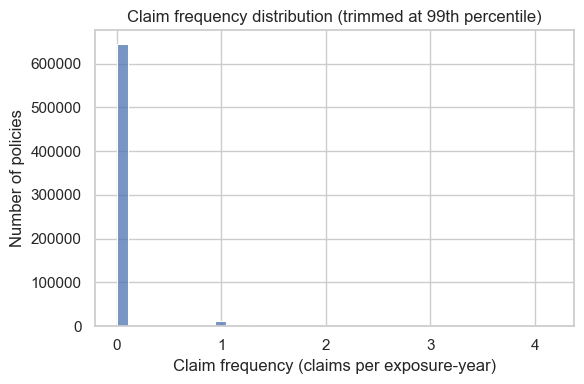

In [15]:
print("=== ClaimNb distribution (sorted by number of claims) ===")
claim_counts = df["ClaimNb"].value_counts().sort_index()
print(claim_counts)

print("\nShare of zero-claim policies: "
      f"{(df['ClaimNb'] == 0).mean():.3f}")
print("Share of policies with at least one claim: "
      f"{(df['ClaimNb'] > 0).mean():.3f}")

# 0 / 1 / 2 / 3+ breakdown – business-friendly view of multi-claim events.
claim_nb_brackets = df["ClaimNb"].clip(upper=3)
claim_nb_bracket_dist = (
    claim_nb_brackets
    .value_counts(normalize=True)
    .sort_index()
)

print("\nRelative frequency of 0,1,2,3+ claims:")
print(claim_nb_bracket_dist)

print("\n=== Exposure summary ===")
print(df["Exposure"].describe())
non_pos_expo = (df["Exposure"] <= 0).sum()
print(f"Number of policies with non-positive exposure: {non_pos_expo}")

# Very short exposure can create noisy, extreme frequencies.
small_expo_mask = df["Exposure"] < 0.1
print("\nShare of policies with Exposure < 0.1:",
      f"{small_expo_mask.mean():.3f}")
print("Share of total exposure from Exposure < 0.1:",
      f"{df.loc[small_expo_mask, 'Exposure'].sum() / df['Exposure'].sum():.3f}")
print("Share of total claims from Exposure < 0.1:",
      f"{df.loc[small_expo_mask, 'ClaimNb'].sum() / df['ClaimNb'].sum():.3f}")

print("\n=== Claim frequency (ClaimNb / Exposure) summary (focused view) ===")
print(df["ClaimFreq"].describe()[["mean", "std", "min", "25%", "50%", "75%", "max"]])

# Trimmed frequency distribution (up to 99th percentile) to visualize the heavy tail.
p99 = df["ClaimFreq"].quantile(0.99)

plt.figure(figsize=(6, 4))
sns.histplot(df.loc[df["ClaimFreq"] <= p99, "ClaimFreq"], bins=40, kde=False)
plt.title("Claim frequency distribution (trimmed at 99th percentile)")
plt.xlabel("Claim frequency (claims per exposure-year)")
plt.ylabel("Number of policies")
plt.tight_layout()
plt.show()